$$\require{mhchem}$$
# Analyse the neb results

In [1]:
%aiida

Loaded AiiDA DB environment - profile name: scanlon-test.

In [2]:
from aiida.orm import StructureData
import matplotlib.pyplot as plt

In [3]:
workchain = load_node('cc231a95-873a-4a2d-ae82-d5226e203e80')  # NOTE - this work has problematic input structures - the end point has high energy
print(workchain.label)

workchain = load_node(579858)
print(workchain.label)

workchain = load_node(581259)
print(workchain.label)

Li2FeOxF2 NEB PATH1 109->87 ARCHER2 RESTART
Li2FeOxF2 NEB PATH1 109->87 ARCHER2 RESTART ENDPOINT UPDATE
Li2FeOxF2 NEB PATH2 109->83 ARCHER2


In [4]:
li2feoxf2_super = load_node('d8c517d9-8c23-4874-a0de-035e406b5df8')

In [5]:
li2feoxf2_super.get_pymatgen().to('cif', 'neb-supercell.cif')

## Pathways
Movement of the vacancy in the original supercell cell 

Note this considers only one atom in a single chain. Each chain is equivalent, but the two Li atoms along the chain is not equivlant. Hence, strictly spacing the NNN pathways  will have different barries, the NN pathways are not affected upon exchange of the initial final structures.

NN - along the chain
* Path 1: 109 -> 87
* Path 2: 109 -> 83

NNN
* Path 3: 109 -> 97
* Path 4: 109 -> 110
* Path 5: 109 -> 86
* Path 6: 109 -> 101


## For standard provenance

## For updaetd
With later updated enpoints

### Tangential forces as reported by VSTS

## Construct NEB frames - pymatgen

In [6]:
from pymatgen.analysis.transition_state import NEBAnalysis

def get_pmg_neb(workchain, energies_override=None, updated_endpoints=False):
    """Get an NEBAnalysis instance for an NEB workchain/calculation"""
    # Energy
    energies = {key: value['energy_without_entropy'] for key, value in workchain.outputs.neb_misc['neb_data'].items()}

    # Query for the energy computed for the end structures
    if updated_endpoints is False:
        q = QueryBuilder()
        q.append(Node, filters={'id': workchain.inputs.initial_structure.id}, tag='root')
        q.append(CalcFunctionNode, with_outgoing='root', project=['attributes.function_name'])
        q.append(StructureData, with_outgoing=CalcFunctionNode, tag='relaxed', project=['label'], 
                 #edge_filters={'label': 'init_structure'}, 
                 edge_project=['label'])
        q.append(WorkflowFactory('vaspu.relax'), with_outgoing='relaxed', project=['label', 'uuid'], tag='relaxation')
        q.append(Dict, with_incoming='relaxation', edge_filters={'label': 'misc'}, project=['attributes.total_energies.energy_extrapolated'])
        q.distinct()
    else:
        # The end point structures have been further relaxed
        q = QueryBuilder()
        q.append(Node, filters={'id': workchain.id}, project=['label', 'uuid'])
        q.append(StructureData, with_outgoing=Node, edge_project=['label'], tag='root')
        q.append(WorkflowFactory('vaspu.relax'), with_outgoing='root', project=['label', 'uuid'], tag='relaxation')
        q.append(Dict, with_incoming='relaxation', edge_filters={'label': 'misc'}, project=['attributes.total_energies.energy_extrapolated'])
        q.distinct()
        
    ends = {}
    end_id = '{:02d}'.format(len(energies) + 1)
    for _, _, _, relax_uuid, eng, label in q.all():
        if label.startswith('init'):
            if '00' in ends:
                print('Duplicated calculation: {relax_uuid} -> {eng} vs existing {existing}'.format(relax_uuid, eng=eng, existing=end['00']))
            else:
                ends['00'] = eng
            
        elif label.startswith('final'):
            if end_id in ends:
                print('Duplicated calculation: {relax_uuid} -> {eng} vs existing {existing}'.format(relax_uuid, eng=eng, existing=end[end_id]))
            else:
                ends[end_id] = eng

    energies.update(ends)
    if energies_override:
        energies.update(energies_override)
    
    # Structure
    neb_frames = []
    for i in range(1, 6):
        atoms = workchain.outputs[f'structure__image_{i:02d}'].get_pymatgen()
        neb_frames.append(atoms)
    neb_frames.insert(0, workchain.inputs.initial_structure.get_pymatgen())
    neb_frames.append(workchain.inputs.final_structure.get_pymatgen())

    # Forces

    forces_list = []
    neb_data = workchain.outputs.neb_misc['neb_data']
    for i in range(1, 6):
        forces = neb_data[f'{i:02d}']['tangents']
        forces_list.append(forces)

    forces_list.insert(0, np.zeros((3, len(workchain.inputs.initial_structure.sites))))
    forces_list.append(np.zeros((3, len(workchain.inputs.initial_structure.sites))))
    
    # Displacement
    r = [0]
    prev = neb_frames[0]
    for st in neb_frames[1:]:
        dists = np.array([s2.distance(s1) for s1, s2 in zip(prev, st)])
        r.append(np.sqrt(np.sum(dists ** 2)))
        prev = st
    r = np.cumsum(r)

    neb_analysis = NEBAnalysis(r, np.array([energies[f'{i:02d}'] for i in range(7)]), forces, neb_frames)
    return neb_analysis

In [ ]:
neb = get_pmg_neb(workchain, updated_endpoints=False)

## Manually plot the NEB results

### $\ce{Li2Fe(C2O4)F2}$ Path 1 - NN - along the chain

In [8]:
import matplotlib.pyplot as plt

from pathlib import Path

def load_and_plot(identifier, updated_endpoints=False, save_structure=True, *args, **kwargs):
    
    workchain = load_node(identifier)
    neb_analysis = get_pmg_neb(workchain, updated_endpoints=updated_endpoints)




    default_args = ['-']
    default_kwargs = {'color': 'xkcd:light blue'}
    default_kwargs.update(kwargs)
    if args:
        default_args = args
        
    x_points = neb_analysis.r
    y_points = neb_analysis.energies - neb_analysis.energies[0]
    plt.plot(x_points, y_points, 's', color=default_kwargs['color'])
    
    x_spline = np.linspace(x_points[0], x_points[-1], 100)
    y_spline = neb_analysis.spline(x_spline)#
    
    plt.plot(x_spline, y_spline, *default_args, **default_kwargs)
    print(neb_analysis.get_extrema(normalize_rxn_coordinate=False))
    plt.xlabel('Reaction coordinate')
    plt.ylabel('Energy (eV)')
    if save_structure:
        folder = kwargs.get('label').replace(' ', '_')
        base = Path(f'neb-export/{folder}')
        base.mkdir(exist_ok=True)
        for idx, s in enumerate(neb_analysis.structures):
            s.to('cif', base / f'frame-{idx}.cif')
    return plt.gca(), neb_analysis

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(1.45, 391.8452428595372)])


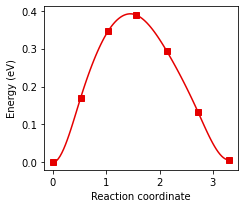

In [9]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
p, ana = load_and_plot('ba0f6f99-3234-40b9-a3dc-ea53e314bc37', updated_endpoints=True, color='xkcd:red', label='Path 1')
plt.tight_layout()
plt.savefig('neb-path1-with-updated-endpoints.svg', dpi=200)

## Path2

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(1.59, 391.1816122536189)])


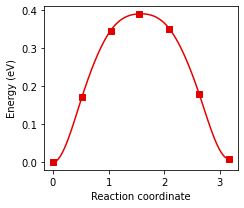

In [10]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
load_and_plot('d3de1259-3eae-473e-baac-042f90269df3', updated_endpoints=False, color='xkcd:red', label='Path 2')
plt.tight_layout()
plt.savefig('neb-path2-finished.svg', dpi=200)

## Path3

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(4.1, 1315.9147571427643)])


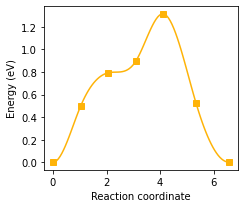

In [11]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
_, ana = load_and_plot('54c8f95a-5fd0-4f13-995e-f673f8ba6775', updated_endpoints=False, color='xkcd:amber', label='Path 3')
plt.tight_layout()
plt.savefig('neb-path3-finished.svg', dpi=200)

## Path4

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([(2.66, 678.0214463073049)], [(1.94, 778.5811243026559), (3.49, 821.2870764037675)])


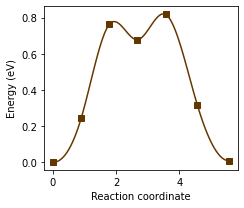

In [12]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
_, ana = load_and_plot('3feff46b-134b-401f-bbdf-4987bb6a55fc', updated_endpoints=False, color='xkcd:brown', label='Path 4')
plt.tight_layout()
plt.savefig('neb-path4-finished.svg', dpi=200)

## Path2 - reduced grid
using grid 0.08 instead of 0.04

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(1.53, 386.8286597308301)])


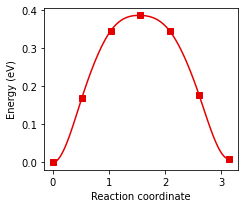

In [13]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
load_and_plot('9c0b1c4f-92b7-4fa0-96e4-8bf88f790827', updated_endpoints=False, color='xkcd:red', label='Path 2-reduced')
plt.tight_layout()
plt.savefig('neb-path2-finished-reduced-grid.svg', dpi=200)

## Plot for path1 and path2

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(1.45, 391.8452428595372)])


/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(1.59, 391.1816122536189)])


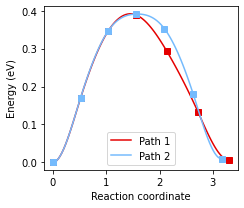

In [19]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
p, ana = load_and_plot('ba0f6f99-3234-40b9-a3dc-ea53e314bc37', updated_endpoints=True, color='xkcd:red', label='Path 1')
load_and_plot('d3de1259-3eae-473e-baac-042f90269df3', updated_endpoints=False, color='xkcd:sky blue', label='Path 2')

plt.tight_layout()
plt.legend()
plt.savefig('neb-path2-path1-combined.svg', dpi=200)

/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([], [(4.1, 1315.9147571427643)])


/home/bonan/miniconda3/envs/aiida-1.0-py3/lib/python3.8/site-packages/aiida/orm/utils/managers.py:94: AiidaDeprecationWarning: dereferencing nodes with links containing double underscores is deprecated, simply replace the double underscores with a single dot instead. For example: 
`self.inputs.some__label` can be written as `self.inputs.some.label` instead.
Support for double underscores will be removed in the future.
  warnings.warn(


([(2.66, 678.0214463073049)], [(1.94, 778.5811243026559), (3.49, 821.2870764037675)])


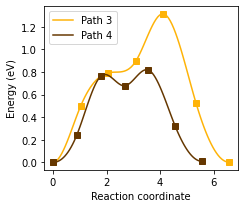

In [20]:
fig, axs = plt.subplots(1, 1, sharey=False, figsize=(3.5, 3))
plt.sca(axs)
_, ana = load_and_plot('54c8f95a-5fd0-4f13-995e-f673f8ba6775', updated_endpoints=False, color='xkcd:amber', label='Path 3')
_, ana = load_and_plot('3feff46b-134b-401f-bbdf-4987bb6a55fc', updated_endpoints=False, color='xkcd:brown', label='Path 4')
plt.tight_layout()
plt.legend()
plt.savefig('neb-path3-path4-combined.svg', dpi=200)